In [1]:
# Load packages
import numpy as np
import pandas as pd
import cv2
import os
import random
import h5py
import scipy.io as sio
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.applications import ResNet50, VGG16
from keras.applications import imagenet_utils
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers import Input
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.datasets import cifar10
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from matplotlib.pyplot import imshow
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
from keras.losses import binary_crossentropy

%matplotlib inline

Using TensorFlow backend.


In [2]:
path_Xtrain = 'drive/My Drive/train'
link_Xtrain = [os.path.join(path_Xtrain, filename) for filename in os.listdir(path_Xtrain) if filename.endswith('jpg')]
link_Xtrain.sort()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'drive/My Drive/train'

In [0]:
path_Ytrain = 'drive/My Drive/train_masks'
link_Ytrain = [os.path.join(path_Ytrain, filename) for filename in os.listdir(path_Ytrain) if filename.endswith('gif')]
link_Ytrain.sort()

In [2]:
def load_and_preprocess(filePaths, pred = True):
    data = []
    for filename in tqdm(filePaths):
        image = load_img(filename)
        image = img_to_array(image)
        image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
        if pred == False:
            image /= 255.
        else:
            image = image[:, :, 0:1]
            image = np.round(image / 255.)
        data.append(image)
    return np.array(data)

In [0]:
X_train = load_and_preprocess(link_Xtrain[:2560], pred = False)

In [0]:
Y_train = load_and_preprocess(link_Ytrain[:2560], pred = True)

100%|██████████| 2560/2560 [02:08<00:00, 19.86it/s]


In [0]:
X_val = load_and_preprocess(link_Xtrain[2560:2768], pred = False)

100%|██████████| 208/208 [00:13<00:00, 15.23it/s]


In [0]:
Y_val = load_and_preprocess(link_Ytrain[2560:2768], pred = True)

100%|██████████| 208/208 [00:10<00:00, 19.68it/s]


In [0]:
def dice_coef(image1, image2):
    return np.sum(image1[image1==image2])*2.0 / (np.sum(image1) + np.sum(image2))

In [3]:
def binary_cross(y_true, y_pred):
    return K.mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true, logits = y_pred), axis = [1, 2, 3])
def binary_acc(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(K.sigmoid(y_pred))), axis = [1, 2, 3])
def dice_coef(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(y_true * K.sigmoid(y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(K.sigmoid(y_pred), axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.sigmoid(y_pred)))/K.sum(y_true)

In [4]:
def unet(pretrained_weights = None, input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1)(conv9)

    model = Model(input = inputs, output = conv10)  
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [0]:
model = unet()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
model.compile(optimizer = Adam(lr = 1e-3), loss = binary_cross, metrics = [dice_coef, binary_acc, true_positive_rate])

In [0]:
H = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size = 8, epochs = 1)

Train on 2560 samples, validate on 208 samples
Epoch 1/1
2560/2560 [==============================] - 408s 159ms/step - loss: 0.6762 - dice_coef: 0.5128 - binary_acc: 0.5326 - true_positive_rate: 0.6835 - val_loss: 0.8824 - val_dice_coef: 0.3029 - val_binary_acc: 0.2024 - val_true_positive_rate: 0.6277


In [0]:
model.save('drive/My Drive/seg_4epochs.hdf5')

In [9]:
model = load_model('seg_4epochs.hdf5', custom_objects = {'binary_cross': binary_cross, 'dice_coef': dice_coef,
                                                                        'true_positive_rate': true_positive_rate, 'binary_acc': binary_acc})

In [0]:
Y_val_pred = model.predict(X_val)

In [7]:
def sigmoid(x):
    return 1/(1+ np.exp(-x))

In [0]:
Y_val_round = np.round(sigmoid(Y_val_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


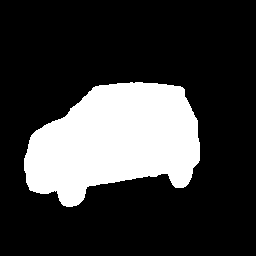

In [0]:
array_to_img(Y_val_round[3])

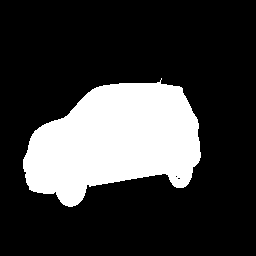

In [0]:
array_to_img(Y_val[3])

In [6]:
def encode(image):
    img_flatten = image.reshape(np.prod(image.shape), )
    img_concat = np.concatenate([[0], img_flatten, [0]])
    runs = np.where(img_concat[1:] != img_concat[:-1])[0] + 1
    runs[1::2] -= runs[::2] 
    return ' '.join(str(x) for x in runs)
  

In [0]:
rle_mask = []
for i in range(Y_val_round.shape[0]):
    rle_mask.append(encode(Y_val_round[i]))
  

In [0]:
img = [x.split(os.path.sep)[-1] for x in link_Xtrain[2560:2768]]

In [0]:
submission = pd.DataFrame({'img': img, 'rle_mask': rle_mask})

In [0]:
submission.head()

,img,rle_mask
0,784ca55262c2_01.jpg,21115 9 21363 26 21615 39 21869 44 22122 49 22...
1,784ca55262c2_02.jpg,21116 21 21363 34 21615 43 21866 50 22116 56 2...
2,784ca55262c2_03.jpg,21119 16 21365 40 21614 54 21860 67 22112 74 2...
3,784ca55262c2_04.jpg,21123 3 21128 8 21366 41 21614 58 21860 75 221...
4,784ca55262c2_05.jpg,21121 5 21129 5 21366 40 21614 58 21860 75 221...


In [0]:
submission = pd.read_csv('drive/My Drive/sample_submission.csv')